# Climate Zone Classifier

In this notebook we:
- import the k-means-cluster-tagged (see previous notebooks) weather station data and the climate-zone maps
- train a series of classifiers on the weather station data after doing train-test splits and k-fold validation sets
- evaluate our model based on a classifying a test set of weather stations with "ground-truth" climate zone classifications
- apply the predicted climate trends from our RMSE-selected time-series fits (see previous notebooks) from each cluster to its corresponding the weather stations
- re-classify the climate zones of the "future" weather stations based on our classifier, and see where there are changes!

### Note that in addition to plotly, seaborn, and scikit-learn, you will also need the geopandas package installed for this notebook to work.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import plotly.express as px
import seaborn as sns

import geopandas as gpd

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,log_loss,f1_score,confusion_matrix,precision_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

sns.set(font_scale=1.4) ##this is just initialized to get the plots all pretty


## Here we import the initial dataframe 

it has weather station data from 1950-202x, most of which we do not need for this classifier bit

In [2]:
df_init = pd.read_csv('./data/combined_GSOY_us48_1950to2024_clustertagged.csv')

# df_init = df_init.drop(columns='Unnamed: 0') #### only necessary if you want to clean up the file a bit

df_init.head()

Unnamed: 0      STATION  DATE  LATITUDE  LONGITUDE  ELEVATION  \
0           0  US009052008  2009   43.7333   -96.6333      482.0   
1           1  US009052008  2010   43.7333   -96.6333      482.0   
2           2  US009052008  2011   43.7333   -96.6333      482.0   
3           3  US009052008  2012   43.7333   -96.6333      482.0   
4           4  US009052008  2013   43.7333   -96.6333      482.0   

                                 NAME   CDSD   CLDD   DP01  ...  MN08  MX06  \
0  SIOUX FALLS ENVIRON. CANADA, SD US  184.3  184.3  115.0  ...   NaN   NaN   
1  SIOUX FALLS ENVIRON. CANADA, SD US  344.1  344.1   95.0  ...   NaN   NaN   
2  SIOUX FALLS ENVIRON. CANADA, SD US  370.3  370.3   98.0  ...   NaN   NaN   
3  SIOUX FALLS ENVIRON. CANADA, SD US  538.1  538.1    NaN  ...   NaN   NaN   
4  SIOUX FALLS ENVIRON. CANADA, SD US  366.8  366.8  120.0  ...   NaN   NaN   

   MX07  MX08  HN09  LN09  MN09  STATE  T_DIFF  Cluster_ID  
0   NaN   NaN   NaN   NaN   NaN     SD   11.62          43  
1   NaN   NaN   NaN   NaN   NaN     SD   11.19          43  
2   NaN   NaN   NaN   NaN   NaN     SD   11.75          43  
3   NaN   NaN   NaN   NaN   NaN     SD   13.16          43  
4   NaN   NaN   NaN   NaN   NaN     SD   11.44          43  

[5 rows x 115 columns]

# here we import the climate zone maps

we drop the last row, since it's just alaska, which we don't try to model

In [3]:
climate_zones = gpd.read_file('./data/Climate_Zones_-_DOE_Building_America_Program.geojson')
climate_zones = climate_zones.drop(17) ##dropping sub-arctic, which is only in alaska
climate_zones

OBJECTID  IECC_Climate_Zone IECC_Moisture_Regime BA_Climate_Zone  Count_  \
0          1                  1                    A       Hot-Humid       1   
1          2                  2                    A       Hot-Humid     222   
2          3                  2                    B         Hot-Dry       6   
3          4                  2                    B       Hot-Humid      14   
4          5                  3                    A       Hot-Humid     192   
5          6                  3                    A     Mixed-Humid     385   
6          7                  3                    B         Hot-Dry     109   
7          8                  3                    C          Marine      14   
8          9                  4                    A     Mixed-Humid     738   
9         10                  4                    B            Cold       1   
10        11                  4                    B       Mixed-Dry      56   
11        12                  4                    C          Marine      38   
12        13                  5                    A            Cold     616   
13        14                  5                    B            Cold     150   
14        15                  6                    A            Cold     337   
15        16                  6                    B            Cold     125   
16        17                  7                  N/A       Very Cold     122   

    AnalysisArea                                           geometry  
0   3.114438e+03  POLYGON ((-80.87399 25.98326, -80.88158 26.258...  
1   4.469746e+05  MULTIPOLYGON (((-81.36627 32.58836, -81.3667 3...  
2   9.945025e+04  POLYGON ((-114.00834 34.27317, -113.99525 34.2...  
3   5.725091e+04  POLYGON ((-99.68967 29.92019, -99.62175 29.919...  
4   3.228507e+05  MULTIPOLYGON (((-76.4237 34.94641, -76.36365 3...  
5   6.354870e+05  MULTIPOLYGON (((-95.03275 37.00078, -94.62038 ...  
6   6.295754e+05  MULTIPOLYGON (((-99.99926 34.74724, -99.99648 ...  
7   5.705420e+04  MULTIPOLYGON (((-122.18833 37.8469, -122.16673...  
8   8.564083e+05  MULTIPOLYGON (((-80.05481 37.95565, -80.03229 ...  
9   1.172465e+04  POLYGON ((-107.19543 34.58358, -107.71841 34.5...  
10  2.965564e+05  MULTIPOLYGON (((-103.38947 38.25592, -103.3895...  
11  1.488795e+05  MULTIPOLYGON (((-120.87465 48.96137, -120.8273...  
12  9.663048e+05  MULTIPOLYGON (((-83.91838 43.917, -83.93812 43...  
13  1.223563e+06  MULTIPOLYGON (((-120.82343 48.54013, -120.8037...  
14  7.649474e+05  MULTIPOLYGON (((-102.96665 48.14003, -102.9066...  
15  8.515772e+05  MULTIPOLYGON (((-104.06299 49.00003, -104.0523...  
16  8.294143e+05  MULTIPOLYGON (((-151.88765 62.80809, -149.5400...

# here we first plot the climate zones 

we are only interested in the Building America "BA" climate zones, defined the EPA to "aid in helping builders to identify the appropriate
climate designation for the counties in which they are building"

the white lines between the different shapes are because of different climate zone classifications (including "international energy conversation code"), but we are only going to focus on the BA

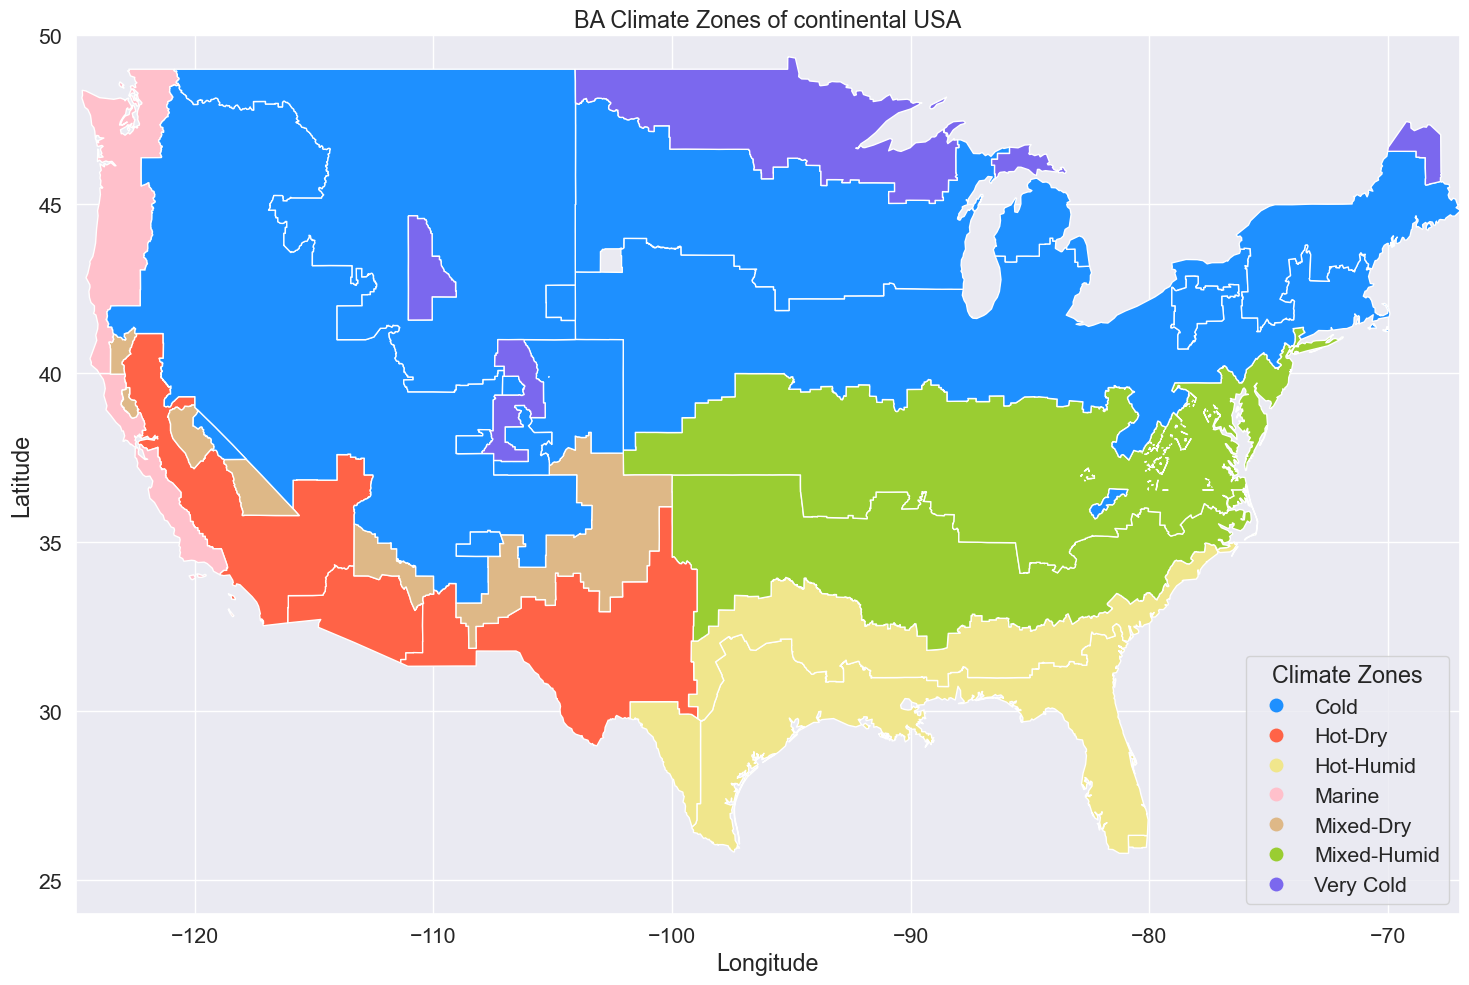

In [4]:
### here we assign the maps some pretty colors
list_climate = np.sort(climate_zones.BA_Climate_Zone.unique())
list_color = ['dodgerblue','tomato','khaki','pink','burlywood','yellowgreen','mediumslateblue']
custom_cmap = ListedColormap(list_color)

dict_colors = {}
for i in range(len(list_climate)):
    dict_colors[list_climate[i]] = list_color[i]

fig, ax = plt.subplots(1, figsize=(15, 15))
ax = climate_zones.plot(column='BA_Climate_Zone',ax=ax,legend=True,
                        legend_kwds={'loc':'lower right','title':'Climate Zones'},cmap=custom_cmap)
ax.set_xlim([-125, -67])
ax.set_ylim([24, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('BA Climate Zones of continental USA')
plt.tight_layout()
plt.savefig('./plots/climate_zones.png',format='png',dpi=300,bbox_inches='tight')
plt.show()


# here we decide on what features to train our classifier on and which year of data we want to use 

## how we choose features

we chose the parameters based on physically-motivated reasons and reasons that are particular to the BA climate zone classifications.  the BA climate zones are defined by a combination of one measurement, "heating degree-days", which is given as:

*"The degree-day measurement is the difference in temperature between the mean (average) outdoor temperature over a 24-hour period and a given
base temperature for a building space, typically 65°F (25°C in Canada). For example, if the mean temperature at a given location for January 3 is 35°F, then the heating degree days measurement for that day is 30 (65 - 35 = 30)."*

and so we include this feature (HTDD) to train our classifier.  However, most of the other measurements for climate zone classifications are **seasonal** data which we do not have access to.  So, we try to make up for this by including features that would make sense -- average, maximum, and minumum temperature (TAVG,TMAX,TMIN, respectively), precipitation/rain (PRCP), snow (SNOW), and elevation (ELEVATION).  As we will see later, most of these parameters are equally important to our final classifier.

## how we chose which year of data to use 

As we have discussed in earlier notebooks, the weather station data are inconsistent.  A given weather station may not have observations every year, and even if it does, it will likely not have it for every feature.  Because we do not 

In [5]:
features = ['TMAX','TAVG','TMIN','PRCP','HTDD','SNOW','ELEVATION']
print(features)

### this is just checking to see which year has the most complete data

for year in range(2005,2024):
    dummy_df = df_init.loc[(df_init.DATE == year)]
    dummy_df = dummy_df.dropna(subset=features, how='any')

    if year == 2005:
        year_max = 2005
        year_len = len(dummy_df)
    if len(dummy_df) > year_len:
        year_max = year
        year_len = len(dummy_df)

### assuming all goes well, this year should be 2010

print(year_max)
print(year_len)

['TMAX', 'TAVG', 'TMIN', 'PRCP', 'HTDD', 'SNOW', 'ELEVATION']
2010
2769


In [6]:
df_cz = df_init.loc[(df_init.DATE == year_max)]

### create new data frame that only includes 2010 weather station data, and drops all stations with NaNs 

df_cz = df_cz.dropna(subset=features, how='any')

points = df_cz[['LONGITUDE','LATITUDE']]

def check_climate_zone(point):
    for i in range(len(climate_zones)):
        polygon = climate_zones.iloc[-1-i].geometry  ### runs backwards because of peculiarity in data 
        climate =  climate_zones.iloc[-1-i].BA_Climate_Zone ### where some weather stations appear in multiple climate zone shapes
        if polygon.contains(point):
            return(climate)
    return(np.nan)

### this takes a bit of time to run
### checks the location of each station and sees which climate zone it's in

climates_list = []
for point in points.values:
    point = Point(point)
    climate = check_climate_zone(point)
    climates_list.append(climate)

print(len(df_cz),len(climates_list))

## are they the same length? they should be!

### drop all weather stations that (somehow) don't have a climate zone label 

df_cz['CLIMATE'] = climates_list
df_cz = df_cz.dropna(subset=['CLIMATE'], how='any')
df_cz.head()

2769 2769


Unnamed: 0      STATION  DATE  LATITUDE  LONGITUDE  ELEVATION  \
74617       74664  USC00010160  2010  32.93500  -85.95556      201.2   
74803       74867  USC00010252  2010  31.30710  -86.52260       76.2   
74816       74880  USC00010260  2010  34.96285  -87.37195      231.6   
75047       75179  USC00010402  2010  31.18200  -87.43900       91.4   
75114       75288  USC00010425  2010  32.59920  -85.46530      166.1   

                         NAME    CDSD    CLDD   DP01  ...  MX06  MX07  MX08  \
74617   ALEXANDER CITY, AL US  1283.7  1283.7   98.0  ...   NaN   NaN   NaN   
74803    ANDALUSIA 3 W, AL US  1344.8  1344.8   76.0  ...   NaN   NaN   NaN   
74816        LEXINGTON, AL US  1023.7  1023.7  108.0  ...   NaN   NaN   NaN   
75047           ATMORE, AL US  1410.5  1410.5   94.0  ...   NaN   NaN   NaN   
75114  AUBURN NUMBER 2, AL US  1281.5  1281.5   96.0  ...   NaN   NaN   NaN   

       HN09  LN09  MN09  STATE  T_DIFF  Cluster_ID      CLIMATE  
74617   NaN   NaN   NaN     AL   14.21          68  Mixed-Humid  
74803   NaN   NaN   NaN     AL   14.53          90    Hot-Humid  
74816   NaN   NaN   NaN     AL   12.55          35  Mixed-Humid  
75047   NaN   NaN   NaN     AL   12.95           0    Hot-Humid  
75114   NaN   NaN   NaN     AL   12.75          68  Mixed-Humid  

[5 rows x 116 columns]

In [7]:
fig = px.scatter_map(df_cz, lat='LATITUDE', lon='LONGITUDE', color='CLIMATE',
                     center=dict(lat=37, lon=-90), zoom=3,size_max=5,
                    map_style="open-street-map",height=600,width=1000,color_discrete_map=dict_colors)
fig.show()

# here we perform a train test split

as a sanity check, we show the train-test split geographically 

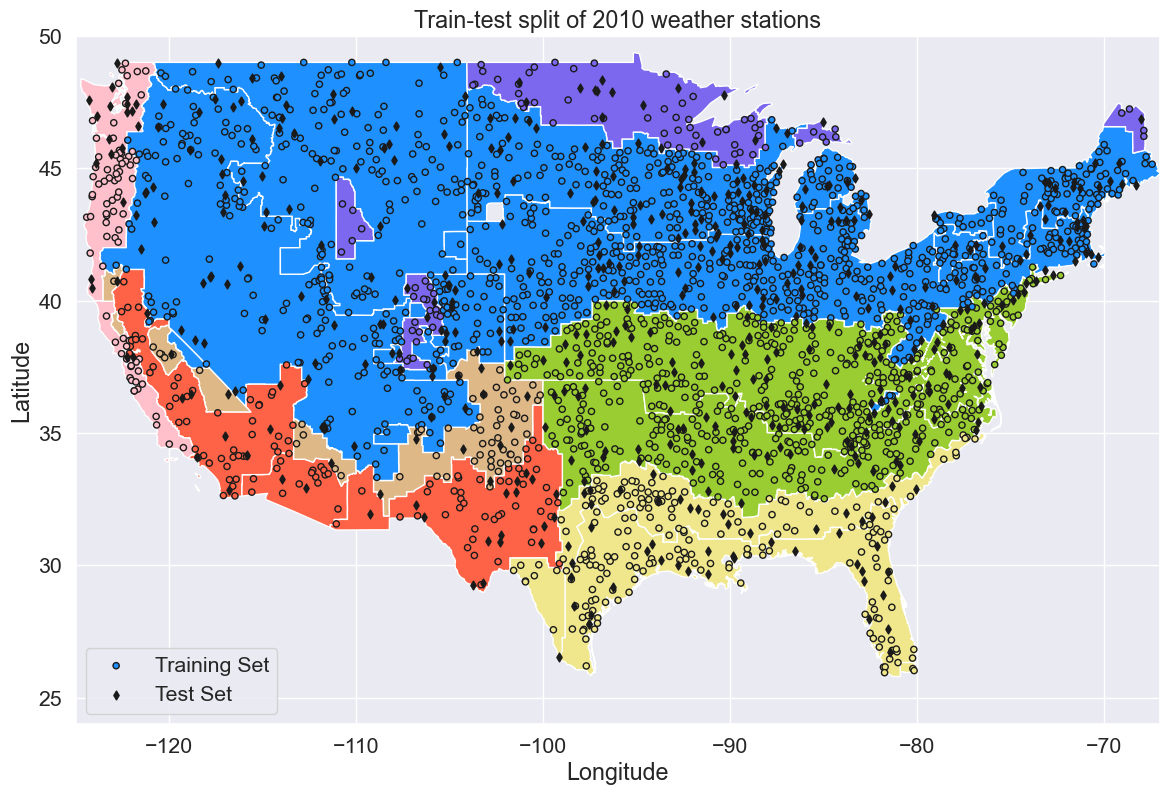

In [8]:
climate_train, climate_test = train_test_split(df_cz.copy(),
                                            shuffle=True,
                                            random_state=646,
                                            stratify=df_cz['CLIMATE'],train_size=0.8)

fig, ax = plt.subplots(1, figsize=(12, 9))
ax = climate_zones.plot(column='BA_Climate_Zone',ax=ax,legend=True,legend_kwds={'loc':'lower right'},cmap=custom_cmap)

train_dummy_color = []
for index,row in climate_train.iterrows():
    train_dummy_color.append(dict_colors[row['CLIMATE']])
test_dummy_color = []
for index,row in climate_test.iterrows():
    test_dummy_color.append(dict_colors[row['CLIMATE']])

ax.scatter(climate_train.LONGITUDE,climate_train.LATITUDE,marker='o',color=train_dummy_color,s=20,edgecolors='k',label='Training Set')
ax.scatter(climate_test.LONGITUDE,climate_test.LATITUDE,marker='d',color='k',s=20,edgecolors='k',label='Test Set')

ax.legend()

ax.set_xlim([-125, -67])
ax.set_ylim([24, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Train-test split of 2010 weather stations')
plt.tight_layout()
plt.savefig('./plots/climate_zones_train_test.png',format='png',dpi=300,bbox_inches='tight')
plt.show()

# here we perform our model selection

we do 10 k-folds, and measure the (weighted-average) accuracy, precision, f1-score, and log-loss for each k-fold

we save these as lists, and store the models in case we want to look at them later

In [9]:
## storing models in lists

rfr_models = []
knn_models = []
LDA_models = []
lgr_models = []

## storing accuracy scores

acc_lgr_vd = []
acc_LDA_vd = []
acc_knn_vd = []
acc_rfr_vd = []

## storing log-loss

ll_LDA_vd = []
ll_knn_vd = []
ll_lgr_vd = []
ll_rfr_vd = []

## storing f1 scores

f1_LDA_vd = []
f1_knn_vd = []
f1_lgr_vd = []
f1_rfr_vd = []

## storing precision 

prc_LDA_vd = []
prc_knn_vd = []
prc_lgr_vd = []
prc_rfr_vd = []

### no recall b/c recall = accuracy whebn using class-weighted averages

strat_kf = StratifiedKFold(n_splits=10,random_state=646,shuffle=True)

for train_index, test_index in strat_kf.split(climate_train[features], climate_train['CLIMATE']):

    climate_tt = climate_train.iloc[train_index]
    climate_vd = climate_train.iloc[test_index]
    
    LDA = LinearDiscriminantAnalysis()
    LDA.fit(climate_tt[features], climate_tt['CLIMATE'])

    knn = Pipeline([('scale', StandardScaler()), ('knn', KNeighborsClassifier(10))])
    ## standard scaler only necessary for kNN, the other models don't need to be scaled
    knn.fit(climate_tt[features], climate_tt['CLIMATE'])

    lgr = LogisticRegression(random_state=646,class_weight='balanced',max_iter=1000,solver='newton-cholesky')
    ## had to choose the newton-cholesky solver, otherwise this didn't converge
    lgr.fit(climate_tt[features], climate_tt['CLIMATE'])

    rfr = RandomForestClassifier(random_state=646,class_weight='balanced_subsample')
    ### random forest should have class_weight = balanced subsample b/c the data are heavily imbalanced!
    rfr.fit(climate_tt[features], climate_tt['CLIMATE'])

    acc_LDA_vd.append(accuracy_score(climate_vd['CLIMATE'], LDA.predict(climate_vd[features])))
    LDA_models.append(LDA)
    
    acc_knn_vd.append(accuracy_score(climate_vd['CLIMATE'], knn.predict(climate_vd[features])))
    knn_models.append(knn)

    acc_lgr_vd.append(accuracy_score(climate_vd['CLIMATE'], lgr.predict(climate_vd[features])))
    lgr_models.append(lgr)
                                            
    acc_rfr_vd.append(accuracy_score(climate_vd['CLIMATE'], rfr.predict(climate_vd[features])))
    rfr_models.append(rfr)

    pcs_LDA = LDA.predict_proba(climate_vd[features])
    pcs_knn = knn.predict_proba(climate_vd[features])
    pcs_lgr = lgr.predict_proba(climate_vd[features])
    pcs_rfr = rfr.predict_proba(climate_vd[features])
    
    ll_LDA_vd.append(log_loss(climate_vd['CLIMATE'], pcs_LDA))
    ll_knn_vd.append(log_loss(climate_vd['CLIMATE'], pcs_knn))
    ll_lgr_vd.append(log_loss(climate_vd['CLIMATE'], pcs_lgr))
    ll_rfr_vd.append(log_loss(climate_vd['CLIMATE'], pcs_rfr))

    f1_LDA_vd.append(f1_score(climate_vd['CLIMATE'], LDA.predict(climate_vd[features]),average='weighted'))
    f1_knn_vd.append(f1_score(climate_vd['CLIMATE'], knn.predict(climate_vd[features]),average='weighted'))
    f1_lgr_vd.append(f1_score(climate_vd['CLIMATE'], lgr.predict(climate_vd[features]),average='weighted'))
    f1_rfr_vd.append(f1_score(climate_vd['CLIMATE'], rfr.predict(climate_vd[features]),average='weighted'))

    prc_LDA_vd.append(precision_score(climate_vd['CLIMATE'], LDA.predict(climate_vd[features]),average='weighted'))
    prc_knn_vd.append(precision_score(climate_vd['CLIMATE'], knn.predict(climate_vd[features]),average='weighted'))
    prc_lgr_vd.append(precision_score(climate_vd['CLIMATE'], lgr.predict(climate_vd[features]),average='weighted'))
    prc_rfr_vd.append(precision_score(climate_vd['CLIMATE'], rfr.predict(climate_vd[features]),average='weighted'))

## what are the mean, std, and max accuracy scores for each model between the validation sets?

In [10]:
print('LDA acc')
print(round(np.mean(acc_LDA_vd),3),round(np.std(acc_LDA_vd),3),round(np.max(acc_LDA_vd),3))
print('KNN acc')
print(round(np.mean(acc_knn_vd),3),round(np.std(acc_knn_vd),3),round(np.max(acc_knn_vd),3))
print('LGR acc')
print(round(np.mean(acc_lgr_vd),3),round(np.std(acc_lgr_vd),3),round(np.max(acc_lgr_vd),3))
print('RFR acc')
print(round(np.mean(acc_rfr_vd),3),round(np.std(acc_rfr_vd),3),round(np.max(acc_rfr_vd),3))

LDA acc
0.841 0.022 0.877
KNN acc
0.886 0.018 0.913
LGR acc
0.794 0.029 0.849
RFR acc
0.899 0.025 0.954


## what are the mean, std, and min log loss for each model between the validation sets?

In [11]:
print('LDA ll')
print(np.mean(ll_LDA_vd),np.std(ll_LDA_vd),np.min(ll_LDA_vd))
print('KNN ll')
print(np.mean(ll_knn_vd),np.std(ll_knn_vd),np.min(ll_knn_vd))
print('LGR ll')
print(np.mean(ll_lgr_vd),np.std(ll_lgr_vd),np.min(ll_lgr_vd))
print('RFR ll')
print(np.mean(ll_rfr_vd),np.std(ll_rfr_vd),np.min(ll_rfr_vd))

LDA ll
0.4745426690960799 0.10916020170295151 0.34799708359164583
KNN ll
0.7407037413406246 0.28118381170506934 0.32499147829645453
LGR ll
0.5808563138400233 0.10731769913618888 0.4202955299257908
RFR ll
0.37044230003142775 0.13556463151575004 0.19525182179408487


## what are the mean, std, and max f1 scores for each model between the validation sets?

In [12]:
print('LDA f1')
print(np.mean(f1_LDA_vd),np.std(f1_LDA_vd),np.max(f1_LDA_vd))
print('KNN f1')
print(np.mean(f1_knn_vd),np.std(f1_knn_vd),np.max(f1_knn_vd))
print('LGR f1')
print(np.mean(f1_lgr_vd),np.std(f1_lgr_vd),np.max(f1_lgr_vd))
print('RFR f1')
print(np.mean(f1_rfr_vd),np.std(f1_rfr_vd),np.max(f1_rfr_vd))

LDA f1
0.8359606005759355 0.021247698195633068 0.8718723186088214
KNN f1
0.8792802445928187 0.01724919757805933 0.9066089024804622
LGR f1
0.8099385249816085 0.027596472361971477 0.8590640065229915
RFR f1
0.8959566677616833 0.024868423587045375 0.9514649483795259


## what are the mean, std, and max precision scores for each model between the validation sets?

In [13]:
print('LDA prc')
print(np.mean(prc_LDA_vd),np.std(prc_LDA_vd),np.max(prc_LDA_vd))
print('KNN prc')
print(np.mean(prc_knn_vd),np.std(prc_knn_vd),np.max(prc_knn_vd))
print('LGR prc')
print(np.mean(prc_lgr_vd),np.std(prc_lgr_vd),np.max(prc_lgr_vd))
print('RFR prc')
print(np.mean(prc_rfr_vd),np.std(prc_rfr_vd),np.max(prc_rfr_vd))

LDA prc
0.8410341588812476 0.019804651619355466 0.8744310357324057
KNN prc
0.8855524581826604 0.020205746891492203 0.9163760647994301
LGR prc
0.8576178730957565 0.024810030529309246 0.8871579627441937
RFR prc
0.8998225132613487 0.025770530598997327 0.9567334407517055


# summarize the results in a neat table

In [14]:
print('Model                   ACC    F1     PRC    LL')
print('Logistic Regression    ',round(100*np.mean(acc_lgr_vd),1),' ',round(100*np.mean(f1_lgr_vd),1),' ',
      round(100*np.mean(prc_lgr_vd),1),' ',round(np.mean(ll_lgr_vd),3))
print('LDA                    ',round(100*np.mean(acc_LDA_vd),1),' ',round(100*np.mean(f1_LDA_vd),1),' ',
      round(100*np.mean(prc_LDA_vd),1),' ',round(np.mean(ll_LDA_vd),3))
print('kNN                    ',round(100*np.mean(acc_knn_vd),1),' ',round(100*np.mean(f1_knn_vd),1),' ',
      round(100*np.mean(prc_knn_vd),1),' ',round(np.mean(ll_knn_vd),3))
print('Random Forest          ',round(100*np.mean(acc_rfr_vd),1),' ',round(100*np.mean(f1_rfr_vd),1),' ',
      round(100*np.mean(prc_rfr_vd),1),' ',round(np.mean(ll_rfr_vd),3))

Model                   ACC    F1     PRC    LL
Logistic Regression     79.4   81.0   85.8   0.581
LDA                     84.1   83.6   84.1   0.475
kNN                     88.6   87.9   88.6   0.741
Random Forest           89.9   89.6   90.0   0.37


## assuming all went well, you should get that the random forest model peformed the best!

Random Forest           91.2   90.8   90.9   0.435


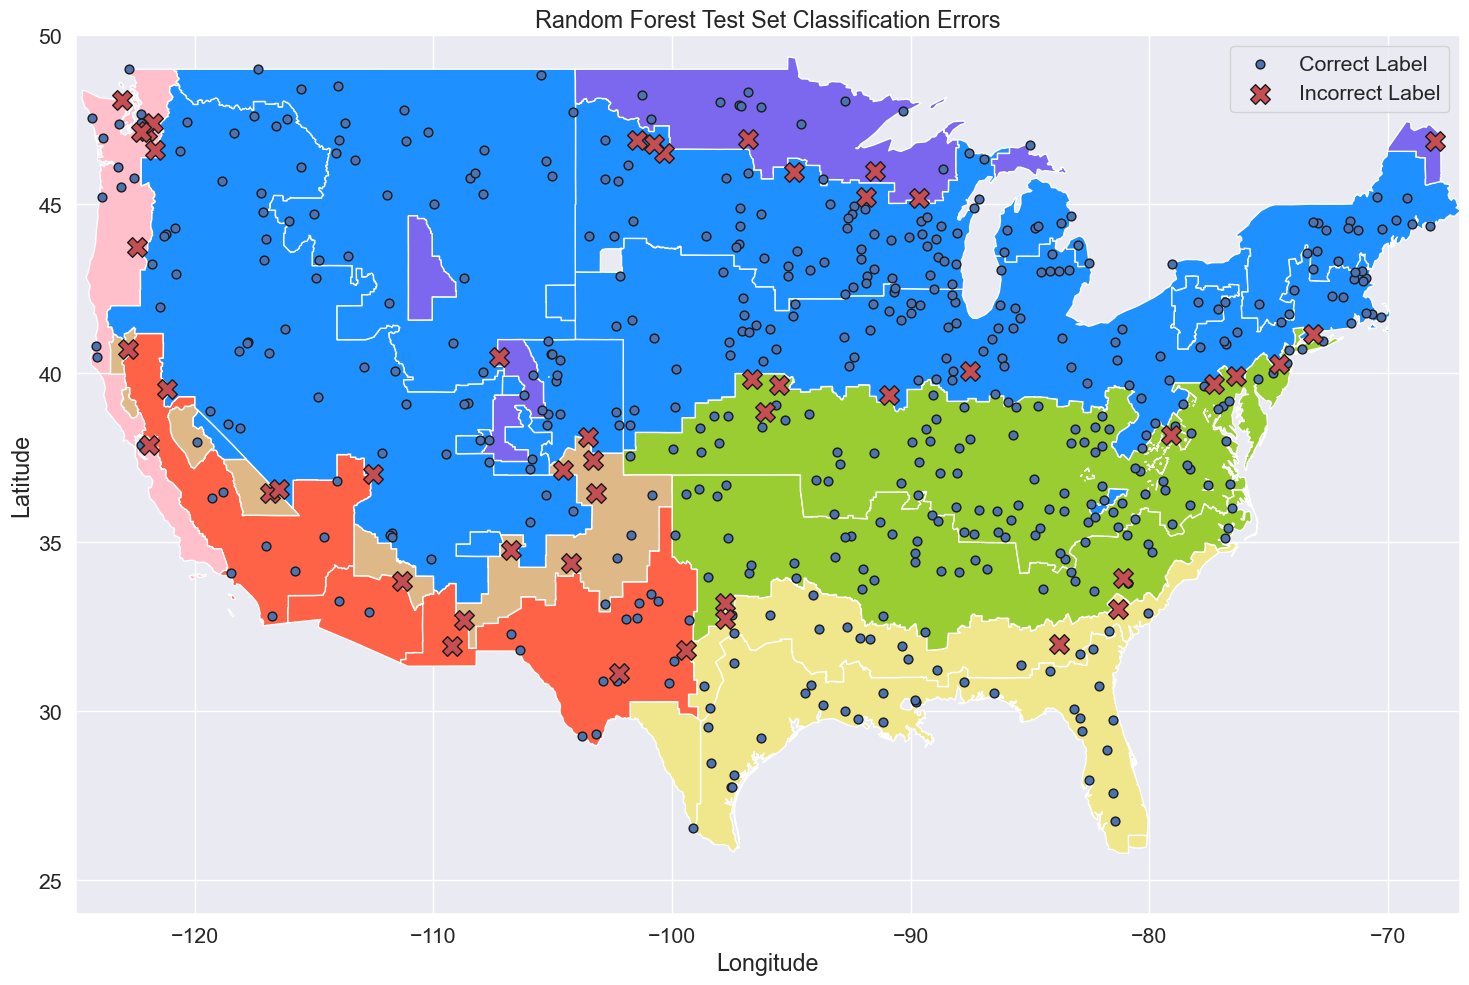

In [15]:
rfr_fin = RandomForestClassifier(random_state=646,class_weight='balanced_subsample')
rfr_fin.fit(climate_train[features],climate_train['CLIMATE'])
acc_test = accuracy_score(climate_test['CLIMATE'], rfr_fin.predict(climate_test[features]))
f1_test = f1_score(climate_test['CLIMATE'], rfr_fin.predict(climate_test[features]),average='weighted')
prc_test = precision_score(climate_test['CLIMATE'], rfr_fin.predict(climate_test[features]),average='weighted')
ll_test = log_loss(climate_test['CLIMATE'],rfr_fin.predict_proba(climate_test[features]))

print('Random Forest          ',round(100*np.mean(acc_test),1),' ',round(100*np.mean(f1_test),1),' ',
      round(100*np.mean(prc_test),1),' ',round(np.mean(ll_test),3))

corr_mask, = np.where(climate_test['CLIMATE']==rfr_fin.predict(climate_test[features]))
inco_mask, = np.where(climate_test['CLIMATE']!=rfr_fin.predict(climate_test[features]))

fig, ax = plt.subplots(1, figsize=(15, 15))
ax = climate_zones.plot(column='BA_Climate_Zone' ,ax=ax,legend=True,legend_kwds={'loc':'lower right'},cmap=custom_cmap)

ax.scatter(climate_test.LONGITUDE.iloc[corr_mask],climate_test.LATITUDE.iloc[corr_mask],marker='o',color='b',s=40,edgecolors='k',
          label='Correct Label')
ax.scatter(climate_test.LONGITUDE.iloc[inco_mask],climate_test.LATITUDE.iloc[inco_mask],marker='X',color='r',s=200,edgecolors='k',
           label='Incorrect Label')

ax.legend()
ax.set_xlim([-125, -67])
ax.set_ylim([24, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.set_title('Random Forest Test Set Classification Errors')
plt.tight_layout()
plt.savefig('./plots/climate_zones_test_class.png',format='png',dpi=300,bbox_inches='tight')
plt.show()

## we can see that the climate zone classifier performs well for the test set, but it still doeds seem have failure modes.

When we look at where geographically the random forest classifier is failing to correctly classify the test set, and the most obvious failure mode is that it fails on these border regions between climate zones.  Since the BA climate zone classification is county-based, the classifier may be running into issues where, a given weather station may actually be more properly characterized by a label, but it exists in a county that is classified as something else.  Geography and elevation come into play here as well.

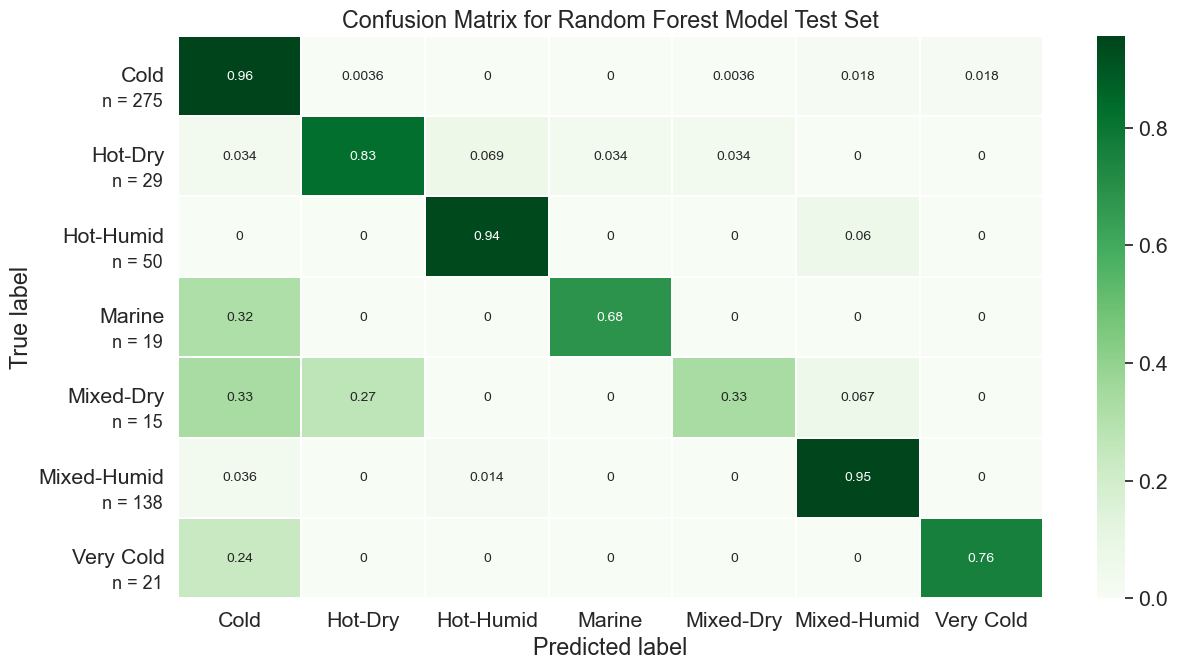

In [16]:
matrix = confusion_matrix(climate_test['CLIMATE'],rfr_fin.predict(climate_test[features]))
num_true = matrix.sum(axis=1)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
class_names = rfr_fin.classes_
# Build the plot
plt.figure(figsize=(13,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names)
plt.yticks(tick_marks2, class_names, rotation=0)
for i in range(len(num_true)):
    plt.text(-0.12,tick_marks2[i]+0.38,'n = '+ str(num_true[i]),ha='right',fontsize=13)
plt.xlabel('Predicted label')
plt.ylabel('True label',)
plt.title('Confusion Matrix for Random Forest Model Test Set')
plt.tight_layout()
plt.savefig('./plots/climate_test_confusion_matrix.png',format='png',dpi=300,bbox_inches='tight')
plt.show()

If we look at the confusion matrix for our classifier on the test set, we see that the classifier struggles most with the “marine” and “mixed-dry” climate zones, which in the BA climate zone classification scheme, are defined using seasonal data that we don’t have, and these are also the labels with the smallest samples, the data are quite imbalance, so it’s also not shocking that the classifier struggles.


# here we apply our predicted climate change trends to our weather station data

We use the fits to the data for each cluster (see previous notebooks) and apply them to each weather station in each cluster.  There is some trickiness with this: we are modeling the trends over time using location-averaged data, but we are applying those trends to data that are **not** location-averaged.  This is somewhat problematic, and if we had more time, we could have come up with a solution to match the climate zone maps, which have county-based, to our weather station data.  

Nevertheless, our main results shouldn't change much.  

The trends we apply are done by calculating the differences between the trended climate data from 2010 and 2050. The actual calaculations are done in other notebooks. 

## Linear vs Quadratic

We use the cluster-based fits.  For each cluster, we fit linear and quadratic trends for each parameter and then computed which of the two models (linear or quadratic) was preferred based on the RMSE.  These preferences are included in "quadratic_prefered.csv", where "True" means the quadratic model was preferred over the linear 

In [17]:
linear_grid = pd.read_csv('./data/2050_linear_diffs.csv')

linear_grid.head()

Unnamed: 0  Cluster_ID        Lon         Lat      TMIN      TMAX  \
0           0           0  31.783964  -88.737544  0.663841  0.072538   
1           1           1  43.950135 -116.547396 -0.209163 -1.908332   
2           2           2  42.250246  -77.656060  0.425137  0.221149   
3           3           3  41.243286 -101.838080  0.478611 -0.038338   
4           4           4  40.588159  -90.744442  0.267752 -0.144423   

       TAVG        SNOW        PRCP        HTDD  
0  0.374711   -2.044872  137.129469  -70.239240  
1 -1.054027 -386.653387  189.338020  352.488867  
2  0.331058   57.182360  103.906773  -85.457732  
3  0.218494  -79.712739   32.582584  -57.649596  
4  0.064443  -22.392708   88.887881  -45.476889

In [18]:
quadratic_grid = pd.read_csv('./data/2050_quadratic_diffs.csv')

quadratic_grid.head()

Unnamed: 0  Cluster_ID        Lon         Lat      TMIN      TMAX  \
0           0           0  31.783964  -88.737544  5.320576  2.971123   
1           1           1  43.950135 -116.547396 -1.915377 -4.687500   
2           2           2  42.250246  -77.656060  2.861092  2.125036   
3           3           3  41.243286 -101.838080  1.360866  1.429855   
4           4           4  40.588159  -90.744442  1.093466  0.733427   

       TAVG        SNOW        PRCP         HTDD  
0  4.166826    9.613820  -29.936784  -789.974737  
1 -3.873229  399.736841  110.030771  1334.879280  
2  2.452658  219.684224  182.019030  -602.191555  
3  1.466401 -301.497910   18.257408  -252.702831  
4  0.921022   99.007357   50.219883  -177.349188

In [19]:
quadratic_mask = pd.read_csv('./data/quadratic_preferred.csv')

quadratic_mask.head()

Unnamed: 0  Cluster ID   TMIN   TMAX   TAVG   SNOW   PRCP   HTDD
0           0           0   True   True   True  False  False   True
1           1           1  False  False  False   True  False  False
2           2           2  False  False  False  False   True  False
3           3           3  False   True  False  False  False  False
4           4           4  False  False  False  False   True  False

In [20]:
#recall ['dodgerblue','tomato','khaki','pink','burlywood','yellowgreen','mediumslateblue']
list_color_new = ['blue','red','yellow','magenta','orange','green','blueviolet']

for i in range(len(list_climate)):
    dict_colors[list_climate[i] +' Future'] = list_color_new[i]

climate_changed = df_cz.copy()

climate_changed['CLIMATE_PRED'] = rfr_fin.predict(climate_changed[features])

## this adds in the climate trends for each parameter for each station, 
## using either the linear or quadratic changes, depending on the model preference based on the RMSE

for index,row in climate_changed.iterrows():
    cluster_ID = row['Cluster_ID']
    for feature in features:
        if feature != 'ELEVATION':
            feature_preference = quadratic_mask.loc[cluster_ID][feature]
            if feature_preference:
                delta = quadratic_grid.loc[cluster_ID][feature]
            else:
                delta = linear_grid.loc[cluster_ID][feature]
            new_value = climate_changed.loc[index][feature]+delta
            
            if feature != 'PRCP' and feature != 'SNOW' and feature != 'HTDD':
                climate_changed.loc[index,feature] = new_value
            else:
                climate_changed.loc[index,feature] = max(new_value,0)
                
climate_changed['CLIMATE_CHNG'] = rfr_fin.predict(climate_changed[features])

# Here we plot how the future weather stations will be classified

we first show an interactive map that includes all weather stations and their classifications, where "future" in the legend means that the weather station will become re-classified as that label

In [21]:
for index,row in climate_changed.iterrows():
    if row['CLIMATE_CHNG'] != row['CLIMATE'] and 'Future' not in row['CLIMATE_CHNG']:
        climate_changed.loc[index,'CLIMATE_CHNG'] = row['CLIMATE_CHNG']+' Future'

fig = px.scatter_map(climate_changed, lat='LATITUDE', lon='LONGITUDE', color='CLIMATE_CHNG',
                     center=dict(lat=37, lon=-90), zoom=3,size_max=5,
                    map_style="open-street-map",height=600,width=1000,color_discrete_map=dict_colors)
fig.show()

# Here we plot the weather stations that will change climate zones after climate change

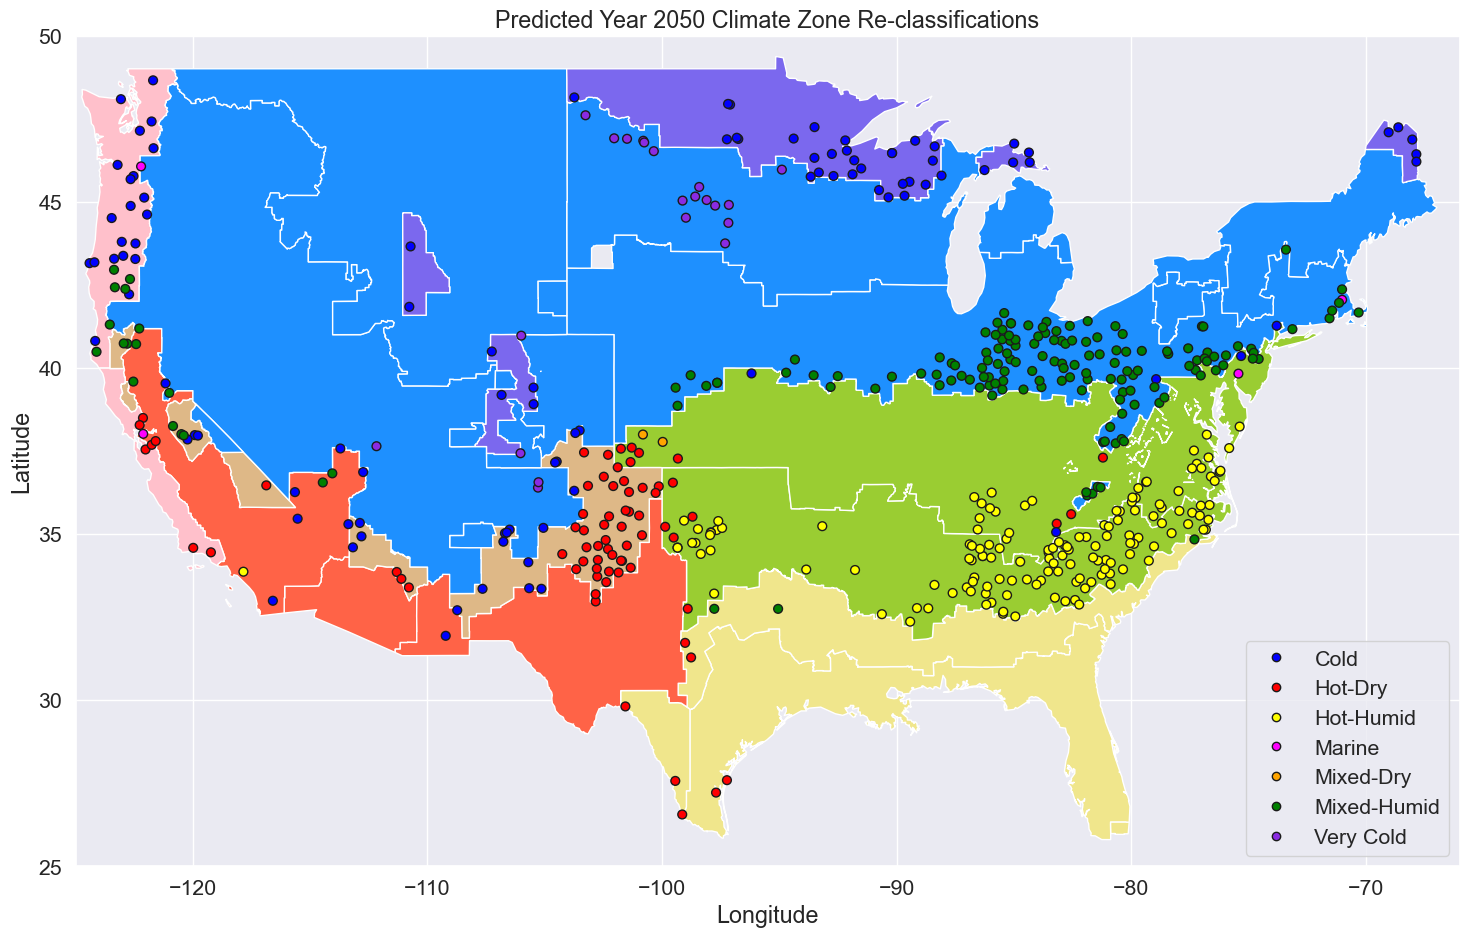

In [22]:
fig, ax = plt.subplots(1, figsize=(15, 15))
ax = climate_zones.plot(column='BA_Climate_Zone' ,ax=ax,legend=True,legend_kwds={'loc':'lower right'},cmap=custom_cmap)

dummy_color_list = []
for index,row in climate_changed.iterrows():
    dummy_color_list.append(dict_colors[row['CLIMATE_CHNG']])
dummy_color_list = np.array(dummy_color_list)

mask, = np.where(climate_changed['CLIMATE_CHNG'] != climate_changed['CLIMATE'])
# mask, = np.where(climate_changed['CLIMATE_CHNG'] != 'filler')

ax.scatter(climate_changed.LONGITUDE.iloc[mask],climate_changed.LATITUDE.iloc[mask],marker='o',color=dummy_color_list[mask],
           s=40,edgecolors='k')

# ax.legend()

for key in sorted(dict_colors.keys()):
    if 'Future' in key:
        ax.plot(0,0,marker='o',color=dict_colors[key],label=key[:-7],ls='None',markeredgecolor='k')
    # else:
    #     ax.plot(0,0,marker='s',color=dict_colors[key],label=key,ls='None')
        
ax.set_xlim([-125, -66])
ax.set_ylim([25, 50])
ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')
ax.legend(loc='lower right')
ax.set_title('Predicted Year 2050 Climate Zone Re-classifications')
plt.tight_layout()
plt.savefig('./plots/climate_zone_change.png',format='png',dpi=300,bbox_inches='tight')
plt.show()

We find that by 2050, there will be large changes in the locations of climate zones, we highlight the most prominent of these changes.  In the northeast and midwest, which were previously classified as cold, will become mixed-humid, and the very cold regions will become just cold.  The coastal south will switch from mixed-humid to hot-humid, and the great-plains areas will go from mixed-dry to hot-dry.  

We do note that in the coastal Oregon and Washington regions, we see changes from Marine to Cold, but if we look back at our confusion matrix in the previous slide, the classifier struggled with properly classifying marine zones, and labeled them incorrectly as cold about a third of the time in the test set, so it’s very likely that these changes we see here are actually just classifier error.

To answer our title, it seems tomorrow’s ohio won’t be today’s texas, but it will be today’s Virginia.  